# Calculate RXE for public dataset, females only based on Apua's script
This has been edited from Apua's script.

In [1]:
import numpy as np
import pandas as pd
from os import environ
from plotnine import *
from pyhere import here
import re, session_info
import statsmodels.api as sm
from functools import lru_cache
from scipy.stats import variation
from warnings import filterwarnings
from scipy.stats import mannwhitneyu
from statsmodels.formula.api import ols
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings('ignore',category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [3]:
environ['NUMEXPR_MAX_THREADS'] = '4'

## Functions

In [4]:
@lru_cache()
def get_pheno():
    return pd.read_csv(here('input/phenotypes/_m/phenotypes.csv'), index_col=0)


@lru_cache()
def get_logTPM(tissue):
    fn = here(f'input/counts/text_files_counts/tpm/_m/{tissue}/gene.log2tpm.csv')
    return pd.read_csv(fn, index_col=0)


@lru_cache()
def get_annotation():
    """
    Get the annotation file for genes.
    """
    fn = here('input/counts/text_files_counts/_m',
              'caudate/gene_annotation.txt')
    return pd.read_csv(fn, sep='\t')

In [5]:
def save_ggplot(p, fn):
    for ext in ['.pdf', '.png', '.svg']:
        p.save(fn+ext, width=10, height=7)
        

def rge(df, chrom):
    return df[df['seqname']==chrom][samples].mean() \
    - df[(df['chrom_type']=='autosome') & (df['seqname']!=chrom)][samples].mean()


def annotate_chrom(df):
    df.loc[:, 'chrom_types'] = 'Other'
    df.loc[df['seqnames'].isin(['chrX', 'chrY']), 'chrom_types'] = 'Allosome'
    df.loc[df['seqnames'].str.contains('chr\d+'), 'chrom_types'] = 'Autosome'
    df.loc[df['seqnames'] == 'chrM', 'chrom_types'] = 'Mitochondria'
    df.loc[df['seqnames'] == 'chrX', 'chrom_types'] = 'X'
    return df

## Load and merge data

In [6]:
log2tpm = pd.DataFrame()
for tissue in ['caudate', 'dlpfc', 'hippocampus']:
    log2tpm = pd.concat([log2tpm, get_logTPM(tissue)], axis=1)
print(log2tpm.shape)
log2tpm.iloc[0:2, 0:5]

(52569, 1217)


,R12864,R12865,R12866,R12867,R12868
name,,,,,
TSPAN6|ENSG00000000003.15,2.441001,3.844446,3.045605,2.788269,2.901279
TNMD|ENSG00000000005.6,0.000000,0.000000,0.082527,0.000000,0.000000


## Annotate TPM

In [7]:
get_annotation().head(2)

,name,seqnames,start,end,width,gene_name
0,TSPAN6|ENSG00000000003.15,chrX,100627108,100639991,12884,TSPAN6
1,TNMD|ENSG00000000005.6,chrX,100584936,100599885,14950,TNMD


In [8]:
df0 = log2tpm.merge(get_annotation().loc[:, ['name', 'gene_name', 'seqnames']], 
                    left_index=True, right_on='name')
df0 = annotate_chrom(df0)
print(df0.shape)
df0.groupby('chrom_types').size()

(52569, 1221)


chrom_types
Allosome          501
Autosome        50034
Mitochondria       14
X                2020
dtype: int64

## Filtering genes

In [9]:
samples = [x for x in log2tpm.columns if re.match('R\d+', x)]
df = df0[(df0[samples].sum(axis=1) >= 0.2 * len(samples)) & 
         (df0['chrom_types'].isin(['X', 'Autosome']))].copy()
df.shape

(24499, 1221)

## Generate RXE

In [10]:
df1  = df.groupby('chrom_types').mean(numeric_only=True).transpose()
df1.head(2)

chrom_types,Autosome,X
R12864,2.332196,2.461731
R12865,2.740215,2.829693


In [11]:
df1['sample'] = df1.index
df1['RXE'] = df1['X'] - df1['Autosome']
df1.head(2)

chrom_types,Autosome,X,sample,RXE
R12864,2.332196,2.461731,R12864,0.129535
R12865,2.740215,2.829693,R12865,0.089478


## Annotated sample IDs

In [12]:
df2 = df1.merge(get_pheno().loc[:, ['RNum', 'Sex', 'Dx', 'Region']], 
                left_index=True, right_on='RNum')
df2.loc[:, ['Region', 'Sex', 'RXE']].groupby(['Region', 'Sex']).describe()

RXE                                                    \
             count      mean       std       min       25%       50%   
Region  Sex                                                            
Caudate F    129.0  0.072434  0.066423 -0.116318  0.037158  0.087259   
        M    289.0  0.073250  0.055947 -0.144156  0.046930  0.085875   
DLPFC   F    125.0  0.105212  0.042601 -0.026092  0.089677  0.119341   
        M    263.0  0.102371  0.068521 -0.919013  0.093479  0.109438   
HIPPO   F    132.0  0.111335  0.032613  0.018946  0.094986  0.114084   
        M    276.0  0.106895  0.032326 -0.005364  0.090518  0.112290   

                                 
                  75%       max  
Region  Sex                      
Caudate F    0.120710  0.180794  
        M    0.111217  0.162486  
DLPFC   F    0.132669  0.171622  
        M    0.124097  0.155076  
HIPPO   F    0.133184  0.178053  
        M    0.127329  0.208088

## Metrics summary

### Variation of RXE

In [13]:
for tissue in ['Caudate', 'DLPFC', 'HIPPO']:
    for sex in ['F', 'M']:
        var = variation(df2[(df2['Region']==tissue) & (df2['Sex']==sex)].RXE)
        print(f'There is {var:.3} variation for {sex} in {tissue}.')

There is 0.913 variation for F in Caudate.
There is 0.762 variation for M in Caudate.
There is 0.403 variation for F in DLPFC.
There is 0.668 variation for M in DLPFC.
There is 0.292 variation for F in HIPPO.
There is 0.302 variation for M in HIPPO.


In [14]:
## Separate out tissues

caudate = df2[(df2['Region']=='Caudate')].copy()
dlpfc = df2[(df2['Region']=='DLPFC')].copy()
hippo = df2[(df2['Region']=='HIPPO')].copy()

### Mann-WhitneyU (Female to Male)

In [15]:
for tissue in ['caudate', 'DLPFC', 'hippocampus']:
    df_config = {'caudate': caudate,'DLPFC': dlpfc,'hippocampus': hippo}
    stat, pval = mannwhitneyu(df_config[tissue][(df_config[tissue]['Sex']=='F')].RXE, 
                              df_config[tissue][(df_config[tissue]['Sex']=='M')].RXE)
    print(f'Mann-WhitneyU for female vs male (RXE) for {tissue}: {pval:.4}')

Mann-WhitneyU for female vs male (RXE) for caudate: 0.5742
Mann-WhitneyU for female vs male (RXE) for DLPFC: 0.04684
Mann-WhitneyU for female vs male (RXE) for hippocampus: 0.1329


### Mann-WhitneyU (CTL vs SZ)

In [16]:
for tissue in ['caudate', 'DLPFC', 'hippocampus']:
    df_config = {'caudate': caudate,'DLPFC': dlpfc,'hippocampus': hippo}
    stat, pval = mannwhitneyu(df_config[tissue][(df_config[tissue]['Dx']=='Control')].RXE, 
                              df_config[tissue][(df_config[tissue]['Dx']=='SCZD')].RXE)
    print(f'Mann-WhitneyU for ctl vs sz (RXE) for {tissue}: {pval:.4}')

Mann-WhitneyU for ctl vs sz (RXE) for caudate: 0.6328
Mann-WhitneyU for ctl vs sz (RXE) for DLPFC: 0.0736
Mann-WhitneyU for ctl vs sz (RXE) for hippocampus: 0.004401


### Subset by sex: diagnosis status

In [17]:
for tissue in ['caudate', 'DLPFC', 'hippocampus']:
    df_config = {'caudate': caudate,'DLPFC': dlpfc,'hippocampus': hippo}
    female = df_config[tissue][(df_config[tissue]['Sex']=='F')].copy()
    male = df_config[tissue][(df_config[tissue]['Sex']=='M')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].RXE, 
                                  female[(female['Dx']=='SCZD')].RXE)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].RXE, 
                                  male[(male['Dx']=='SCZD')].RXE)
    print(f'Mann-WhitneyU of female, ctl vs sz (RXE) for {tissue}: {pval_f:.4}')
    print(f'Mann-WhitneyU of male, ctl vs sz (RXE) for {tissue}: {pval_m:.4}')

Mann-WhitneyU of female, ctl vs sz (RXE) for caudate: 0.2795
Mann-WhitneyU of male, ctl vs sz (RXE) for caudate: 0.1496
Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.6639
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.06367
Mann-WhitneyU of female, ctl vs sz (RXE) for hippocampus: 0.2548
Mann-WhitneyU of male, ctl vs sz (RXE) for hippocampus: 0.004064


### X chromosome expression differences

In [18]:
for tissue in ['caudate', 'DLPFC', 'hippocampus']:
    df_config = {'caudate': caudate,'DLPFC': dlpfc,'hippocampus': hippo}
    female = df_config[tissue][(df_config[tissue]['Sex']=='F')].copy()
    male = df_config[tissue][(df_config[tissue]['Sex']=='M')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].X, 
                                  female[(female['Dx']=='SCZD')].X)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].X, 
                                  male[(male['Dx']=='SCZD')].X)
    print(f'Mann-WhitneyU of female, ctl vs sz (RXE) for {tissue}: {pval_f:.4}')
    print(f'Mann-WhitneyU of male, ctl vs sz (RXE) for {tissue}: {pval_m:.4}')

Mann-WhitneyU of female, ctl vs sz (RXE) for caudate: 0.132
Mann-WhitneyU of male, ctl vs sz (RXE) for caudate: 0.2937
Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.2231
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.01622
Mann-WhitneyU of female, ctl vs sz (RXE) for hippocampus: 0.9944
Mann-WhitneyU of male, ctl vs sz (RXE) for hippocampus: 0.1167


### Autosome expression

In [19]:
for tissue in ['caudate', 'DLPFC', 'hippocampus']:
    df_config = {'caudate': caudate,
                 'DLPFC': dlpfc, 
                 'hippocampus': hippo}
    female = df_config[tissue][(df_config[tissue]['Sex']=='F')].copy()
    male = df_config[tissue][(df_config[tissue]['Sex']=='M')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].Autosome, 
                                  female[(female['Dx']=='SCZD')].Autosome)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].Autosome, 
                                  male[(male['Dx']=='SCZD')].Autosome)
    print(f'Mann-WhitneyU of female, ctl vs sz (RXE) for {tissue}: {pval_f:.4}')
    print(f'Mann-WhitneyU of male, ctl vs sz (RXE) for {tissue}: {pval_m:.4}')

Mann-WhitneyU of female, ctl vs sz (RXE) for caudate: 0.2489
Mann-WhitneyU of male, ctl vs sz (RXE) for caudate: 0.2242
Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.251
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.006911
Mann-WhitneyU of female, ctl vs sz (RXE) for hippocampus: 0.7817
Mann-WhitneyU of male, ctl vs sz (RXE) for hippocampus: 0.6085


### Interaction model

In [20]:
df2.Sex = df2.Sex.astype('category').cat.rename_categories({'F': 'Female', 'M': 'Male'})
df2.Dx = df2.Dx.astype('category').cat.rename_categories({'SCZD': 'SZ', 'Control': 'CTL'})
df2.head(2)

,Autosome,X,sample,RXE,RNum,Sex,Dx,Region
SAMPLE_ID,,,,,,,,
R12864_H5FM2BBXX,2.332196,2.461731,R12864,0.129535,R12864,Female,SZ,Caudate
R12865_H5FM2BBXX,2.740215,2.829693,R12865,0.089478,R12865,Male,SZ,Caudate


In [21]:
df3 = df2.reset_index()[['RNum', 'RXE', 'Sex', 'Dx', 'Region']].set_index('RNum')
df3[df3.columns[1]] = df3.Sex.cat.codes
df3[df3.columns[2]] = df3.Dx.cat.codes
df3[df3.columns[3]] = df3.Region.astype('category').cat.codes
df3.head(2)

,RXE,Sex,Dx,Region
RNum,,,,
R12864,0.129535,0,1,0
R12865,0.089478,1,1,0


In [22]:
anova_df = df2.loc[:,['RXE','Sex','Dx','Region']]

# ANOVA results with combinations of 2 groups:
formula = 'RXE ~ C(Sex) + C(Dx) + C(Region) + C(Sex):C(Dx) + C(Sex):C(Region) + C(Dx):C(Region)'
lm = ols(formula, anova_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df          F        PR(>F)
C(Sex)            0.001895     1.0   0.690473  4.061684e-01
C(Dx)             0.030385     1.0  11.072889  9.024554e-04
C(Region)         0.296575     2.0  54.038442  3.354717e-23
C(Sex):C(Dx)      0.010747     1.0   3.916503  4.804177e-02
C(Sex):C(Region)  0.001777     2.0   0.323846  7.234250e-01
C(Dx):C(Region)   0.003186     2.0   0.580494  5.597787e-01
Residual          3.303914  1204.0        NaN           NaN


#### By tissue interaction

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Assumes parametric

for tissue in ['caudate', 'DLPFC', 'hippocampus']:
    df_config = {'caudate': caudate,'DLPFC': dlpfc,'hippocampus': hippo}
    anova_df = df_config[tissue].loc[:, ['RXE', 'Sex', 'Dx']]
    # ANOVA results with combinations of 2 groups:
    formula = 'RXE ~ C(Sex) + C(Dx) + C(Sex):C(Dx)'
    lm = ols(formula, anova_df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(tissue)
    print(table)
    print('\n')
    anova_df['combination'] = anova_df.Sex.astype('str') + ' / ' + anova_df.Dx.astype('str')
    anova_df['combination'] = anova_df.Sex.astype('str') + ' / ' + anova_df.Dx.astype('str')
    # perform multiple pairwise comparison (Tukey HSD)
    m_comp = pairwise_tukeyhsd(endog=anova_df['RXE'], groups=anova_df['combination'], alpha=0.05)
    # coerce the tukeyhsd table to a DataFrame
    tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
    if tukey_data[(tukey_data['p-adj'] < 0.05)].shape[0] == 0:
        print('There is no significant interactions!')
    else:
        print(tukey_data[(tukey_data['p-adj'] < 0.05)])
    print('\n')

caudate
                sum_sq     df         F    PR(>F)
C(Sex)        0.000021    1.0  0.006019  0.938196
C(Dx)         0.003460    1.0  0.983331  0.321957
C(Sex):C(Dx)  0.006188    1.0  1.758856  0.185499
Residual      1.456543  414.0       NaN       NaN


There is no significant interactions!


DLPFC
                sum_sq     df         F    PR(>F)
C(Sex)        0.000870    1.0  0.232827  0.629711
C(Dx)         0.015831    1.0  4.236993  0.040226
C(Sex):C(Dx)  0.004534    1.0  1.213578  0.271315
Residual      1.434789  384.0       NaN       NaN


There is no significant interactions!


hippocampus
                sum_sq     df          F    PR(>F)
C(Sex)        0.002564    1.0   2.516841  0.113418
C(Dx)         0.014101    1.0  13.843822  0.000227
C(Sex):C(Dx)  0.001110    1.0   1.089551  0.297195
Residual      0.411496  404.0        NaN       NaN


        group1    group2  meandiff   p-adj   lower   upper  reject
2  F / Control  M / SCZD   -0.0176  0.0022 -0.0303 -0.0049    True

## Plot RXE

/users/jbenjami/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


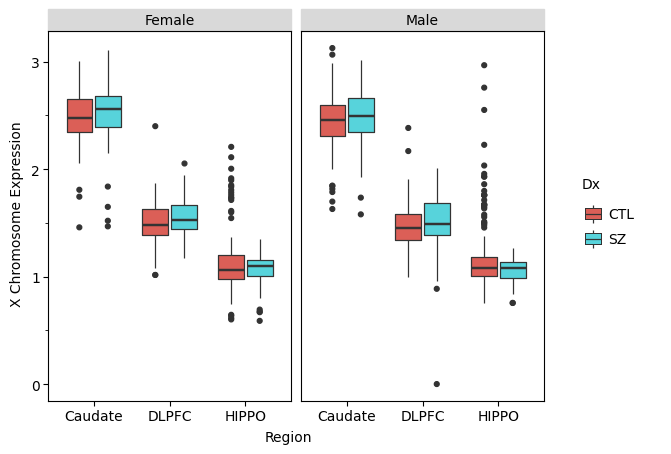

<ggplot: (8792500059356)>

In [24]:
p = ggplot(df2, aes(x='Region', y='X', fill='Dx')) \
    + geom_boxplot() \
    + facet_grid('~Sex')\
    + ylab('X Chromosome Expression')\
    + theme_matplotlib()
p

/users/jbenjami/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


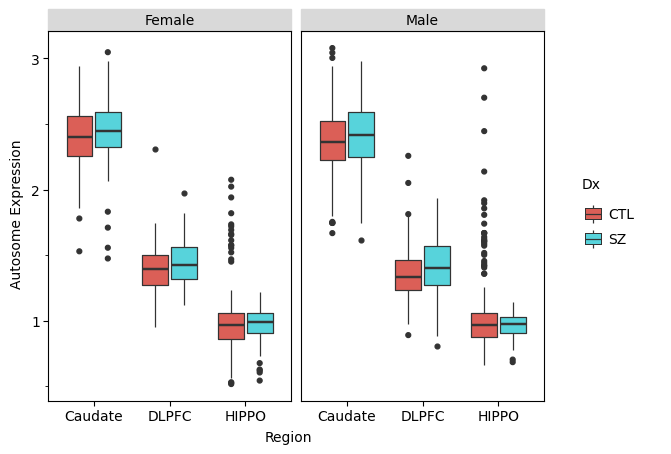

<ggplot: (8792499901486)>

In [25]:
p = ggplot(df2, aes(x='Region', y='Autosome', fill='Dx')) \
    + geom_boxplot() \
    + facet_grid('~Sex')\
    + ylab('Autosome Expression')\
    + theme_matplotlib()
p

/users/jbenjami/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


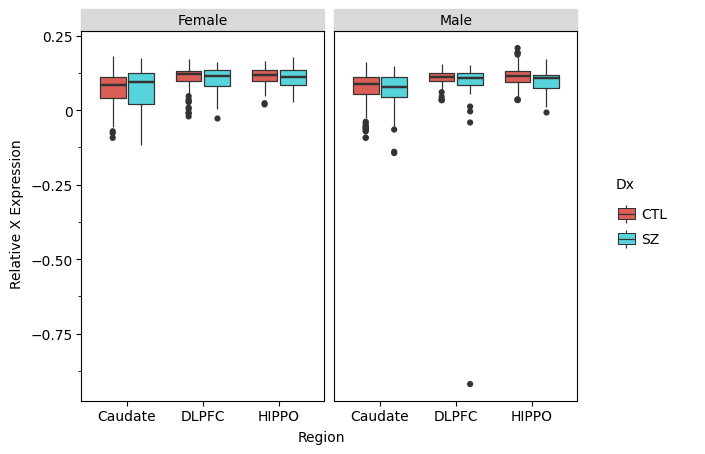

<ggplot: (8792499801338)>

In [26]:
p = ggplot(df2, aes(x='Region', y='RXE', fill='Dx')) \
    + geom_boxplot() \
    + facet_grid('~Sex')\
    + ylab('Relative X Expression')\
    + theme_matplotlib()
p

/users/jbenjami/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


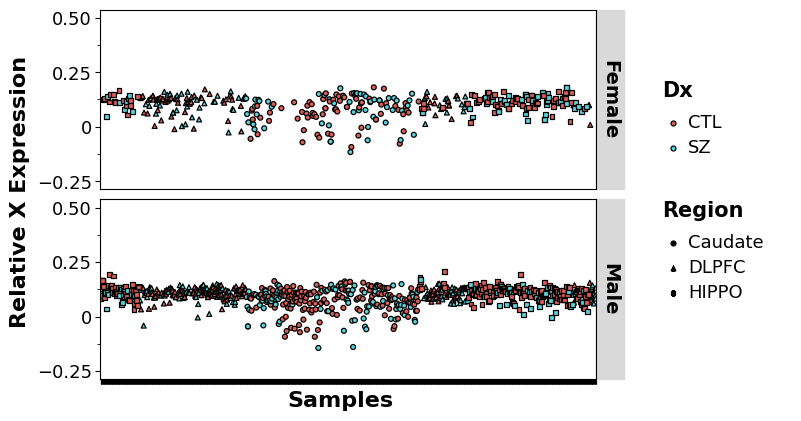

<ggplot: (8792499708100)>

In [27]:
p = ggplot(df2, aes(x='sample', y='RXE', fill='Dx', shape='Region')) \
+ geom_point() + ylim([-0.25, 0.5]) + xlab('Samples')\
+ ylab('Relative X Expression') + facet_grid('Sex~.')\
+ theme_matplotlib() \
+ theme(axis_text_x=element_blank(), 
        axis_text=element_text(size=13), 
        legend_title=element_text(size=15, face='bold'), 
        legend_text=element_text(size=13),
        axis_title=element_text(size=16, face='bold'), 
        strip_text=element_text(size=14, face='bold'))
p

In [28]:
df2.to_csv('RXE_public.csv')
save_ggplot(p, 'RXE_public_bySex')

/users/jbenjami/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/users/jbenjami/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/users/jbenjami/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


## Session information

In [29]:
session_info.show()